# Estimating Covariance and Expected Returns

In [8]:
import numpy as np 
import pandas as pd 
import edhec_risk_ins as eri 

%load_ext autoreload 
%autoreload 2

ins_rets = eri.get_ins_returns(49,weighting="ew")["1974":]
ins_mcap = eri.get_ind_market_caps(49, weights=True)["1974":]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher Var(5%),HistoricCVaR(5%),Sharp Ratio,Max Drawdown
EW,0.131606,0.187437,-0.616296,6.771301,0.082035,0.122226,0.122226,-0.598060
CW,0.131382,0.187040,-0.555883,5.825438,0.082040,0.120070,0.120070,-0.589473


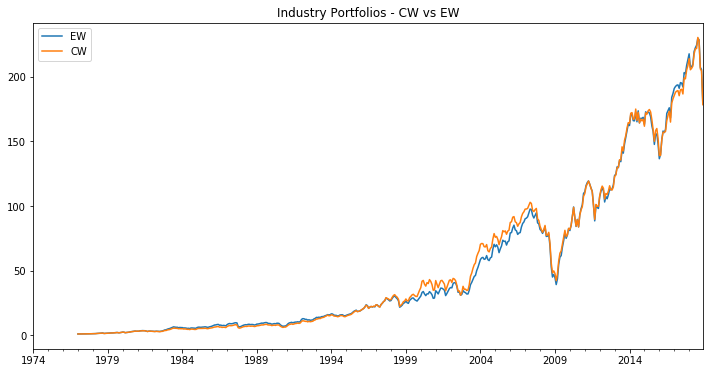

In [10]:
ewr = eri.backtest_ws(ins_rets, estimation_window=36,weighting=eri.weight_ew)
cwr = eri.backtest_ws(ins_rets,estimation_window=36,weighting=eri.weight_cw,cap_weights = ins_mcap)
btr = pd.DataFrame({"EW":ewr,"CW":cwr})
(1+btr).cumprod().plot(figsize=(12,6),title="Industry Portfolios - CW vs EW")
eri.Summary_Stats(btr.dropna())

## Building the GMV portfolio

In [11]:
def sample_cov(r,**kwargs):
    """
    Returns the sample covariance of the supplied returns 
    """
    return r.cov()

def weight_gmv(r,cov_estimator=sample_cov,**kwargs):
    """
    Produces the weights of the GMV portfolio given a covariance matrix of the returns
    """
    est_cov = cov_estimator(r,**kwargs)
    return eri.gmv(est_cov)

In [12]:
mv_s_r = eri.backtest_ws(ins_rets,estimation_window=36,weighting=weight_gmv,cov_estimator = sample_cov)

The step above take huge amount of time to run.

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher Var(5%),HistoricCVaR(5%),Sharp Ratio,Max Drawdown
EW,0.131606,0.187437,-0.616296,6.771301,0.082035,0.122226,0.122226,-0.598060
CW,0.131382,0.187040,-0.555883,5.825438,0.082040,0.120070,0.120070,-0.589473
GMV-Sample,0.153093,0.116303,-0.811389,6.408558,0.047674,0.072557,0.072557,-0.463909


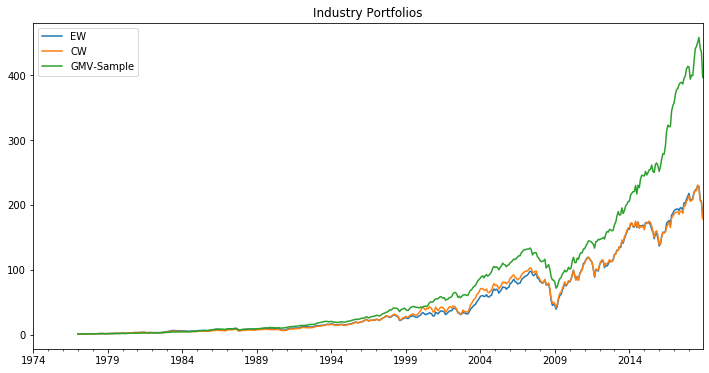

In [13]:
btr_2 = pd.DataFrame({"EW":ewr,"CW":cwr,"GMV-Sample":mv_s_r})
(1+btr_2).cumprod().plot(figsize=(12,6),title="Industry Portfolios")
eri.Summary_Stats(btr_2.dropna())

Constant correlation estimator. Intuition: take the sample correlation matrix compute the average correlation and then reconstruct the cov matrix.

$$ \rho_{ij} = \frac{ \sigma_{ij} } { \sqrt{ \sigma_{ii}  \sigma_{jj} } } $$

In [14]:
def cc_cov(r,**kwargs):
    """
    Estimate a cov matrix using constant correlation
    """
    rhos = r.corr()
    n=rhos.shape[0]
    rho_bar = (rhos.values.sum()-n)/(n*(n-1)) #calculate the average rho
    ccor = np.full_like(rhos,rho_bar)
    np.fill_diagonal(ccor,1.)
    sd = r.std()
    ccov = ccor*np.outer(sd,sd)
    return pd.DataFrame(ccov,index=r.columns,columns=r.columns)

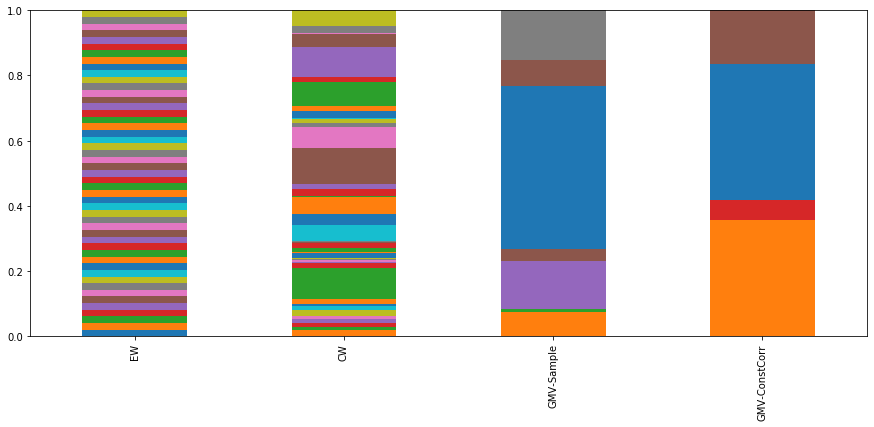

In [17]:
wts = pd.DataFrame({
    "EW": eri.weight_ew(ins_rets["2016":]),
    "CW": eri.weight_cw(ins_rets["2016":], cap_weights=ins_mcap),
    "GMV-Sample": weight_gmv(ins_rets["2016":], cov_estimator=sample_cov),
    "GMV-ConstCorr": weight_gmv(ins_rets["2016":], cov_estimator=cc_cov),
})
wts.T.plot.bar(stacked=True, figsize=(15,6), legend=False);

In [18]:
mv_cc_r=eri.backtest_ws(ins_rets,estimation_window=36,weighting=weight_gmv,cov_estimator=cc_cov)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher Var(5%),HistoricCVaR(5%),Sharp Ratio,Max Drawdown
EW,0.131606,0.187437,-0.616296,6.771301,0.082035,0.122226,0.122226,-0.598060
CW,0.131382,0.187040,-0.555883,5.825438,0.082040,0.120070,0.120070,-0.589473
GMV-Sample,0.153093,0.116303,-0.811389,6.408558,0.047674,0.072557,0.072557,-0.463909
GMV-CC,0.132374,0.115347,-0.890967,6.072431,0.049609,0.075268,0.075268,-0.524087


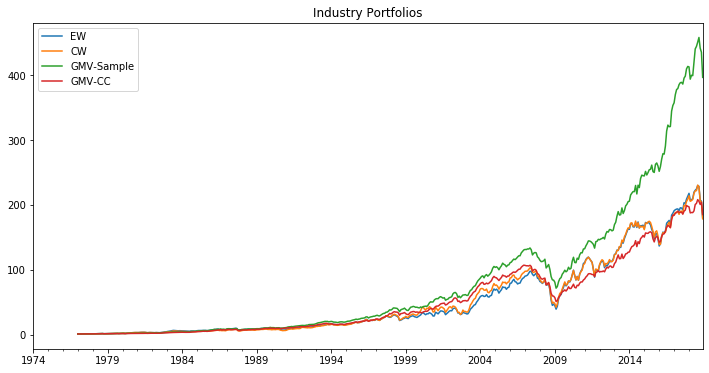

In [21]:
btr_3 = pd.DataFrame({"EW":ewr,"CW":cwr,"GMV-Sample":mv_s_r,"GMV-CC":mv_cc_r})
(1+btr_3).cumprod().plot(figsize=(12,6),title="Industry Portfolios")
eri.Summary_Stats(btr_3.dropna())

## Statistical Shrinkage

we can mix the model and sample estimates by choosing a shrinkage parameter. You can either let the numbers dictate an optimal shrinkage value for $\delta$ although in practice many practitioners choose 0.5. Let's implement a simple shrinkage based covariance estimator that shrinks towards the constant correlation estimate. 

In [22]:
def shrinkage_cov(r,delta=0.5,**kwargs):
    """
    Cov estimator that shrinks between the sample cov and the constant correlation cov
    """
    prior = cc_cov(r,**kwargs)
    sample = sample_cov(r,**kwargs)
    return delta*prior + (1-delta) * sample

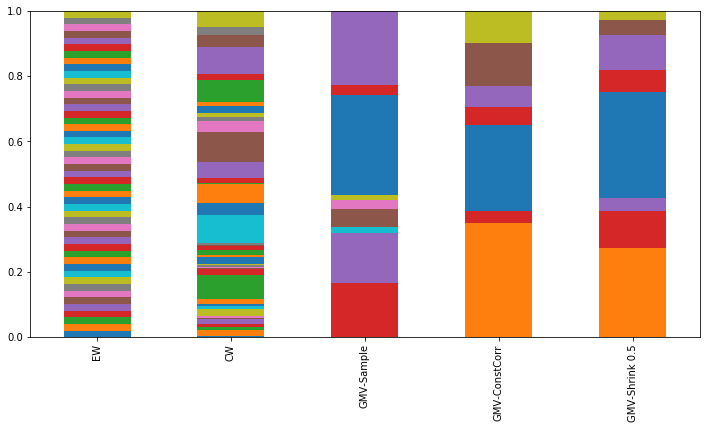

In [24]:
wts = pd.DataFrame({
    "EW": eri.weight_ew(ins_rets["2013":]),
    "CW": eri.weight_cw(ins_rets["2013":], cap_weights=ins_mcap),
    "GMV-Sample": weight_gmv(ins_rets["2013":], cov_estimator=sample_cov),
    "GMV-ConstCorr": weight_gmv(ins_rets["2013":], cov_estimator=cc_cov),
    "GMV-Shrink 0.5": weight_gmv(ins_rets["2013":], cov_estimator=shrinkage_cov),
})
wts.T.plot.bar(stacked=True, figsize=(12,6), legend=False)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher Var(5%),HistoricCVaR(5%),Sharp Ratio,Max Drawdown
EW,0.131606,0.187437,-0.616296,6.771301,0.082035,0.122226,0.122226,-0.598060
CW,0.131382,0.187040,-0.555883,5.825438,0.082040,0.120070,0.120070,-0.589473
GMV-Sample,0.153093,0.116303,-0.811389,6.408558,0.047674,0.072557,0.072557,-0.463909
GMV-CC,0.132374,0.115347,-0.890967,6.072431,0.049609,0.075268,0.075268,-0.524087
GMV-Shrink 0.5,0.138506,0.114873,-0.886403,6.306038,0.048716,0.074239,0.074239,-0.518470


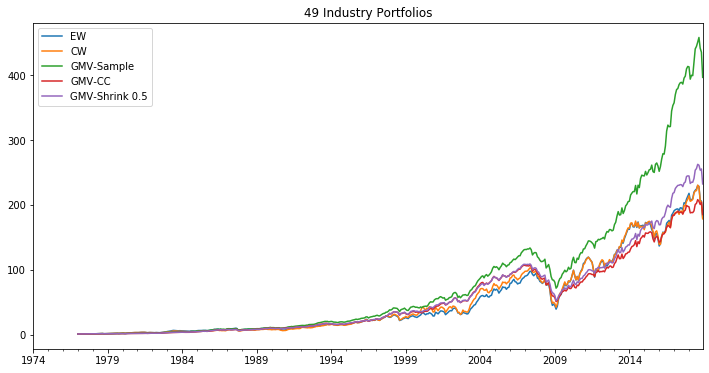

In [27]:
mv_sh_r = eri.backtest_ws(ins_rets, estimation_window=36, weighting=weight_gmv, cov_estimator=shrinkage_cov, delta=0.5)
btr_4 = pd.DataFrame({"EW": ewr, "CW": cwr, "GMV-Sample": mv_s_r, "GMV-CC": mv_cc_r, 'GMV-Shrink 0.5': mv_sh_r})
(1+btr_4).cumprod().plot(figsize=(12,6), title="49 Industry Portfolios")
eri.Summary_Stats(btr_4.dropna())